In [21]:
import os
import numpy as np
import random
import pandas as pd
from numba import jit

import os 
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict


In [22]:
file_user = "../data/weibo/userProfile.pkl"
file_labels = "../data/weibo/labels_1000.pkl"
file_edges = "../data/weibo/edges_1000.pkl"
file_topics = "../data/weibo/topics_8.pkl"

#### Parameters

In [5]:
DATE_VAR = ['created_at']
NUM_VAR = ['bi_followers_count', 'followers_count', 'friends_count', 'statuses_count']
CAT_VAR = ['city', 'verified', 'province', 'verified_type', 'gender']

FEATURES = ['followers_count', 'friends_count', 'statuses_count', 'verified', 'gender']

N_INFLUENCERS = 100
N_TARGETS = 1000
N_FEATURES = 2 * len(FEATURES)
N_INSTANCES = 10
N_TOPICS = 8
PROB_TYPE = 'LP'

#### Imports

User data

In [6]:
df_user_orig = pd.read_pickle(file_user)
df_user_orig.index = df_user_orig['id'].astype(np.int64)

print("df_user_orig : \n" + df_user_orig.head(5).to_markdown())
print(f"shape : {df_user_orig.shape}\n" )


df_user_orig : 
|         id |         id |   bi_followers_count |   city | verified   |   followers_count |   province |   friends_count | gender   | created_at          |   verified_type |   statuses_count |
|-----------:|-----------:|---------------------:|-------:|:-----------|------------------:|-----------:|----------------:|:---------|:--------------------|----------------:|-----------------:|
| 1657151084 | 1657151084 |                    0 |      5 | False      |                33 |         31 |             162 | m        | 2009-10-29 22:20:41 |              -1 |                0 |
| 1657149732 | 1657149732 |                    0 |      9 | False      |                16 |         62 |              27 | m        | 2009-10-29 20:48:01 |              -1 |               11 |
| 1657148500 | 1657148500 |                    4 |     20 | False      |                79 |         31 |              29 | m        | 2009-12-12 18:10:42 |              -1 |               25 |
| 1657146942 |

Transformation of user data

In [7]:
#FE
df_user = df_user_orig[FEATURES]
df_user['followers_count'] = df_user['followers_count'].apply(lambda x : np.log(max(x, 0) + 1)) / 10
df_user['friends_count'] = df_user['friends_count'].apply(lambda x : np.log(max(x, 0) + 1)) / 8
df_user['statuses_count'] = df_user['statuses_count'].apply(lambda x : np.log(max(x, 0) + 1)) / 10
df_user['verified'] = df_user.verified.apply(lambda x : 1 if x =='True' else 0)
df_user['gender'] = df_user.gender.cat.codes
df_user = df_user.groupby(df_user.index).max() #some userid were 2 time in the dataset 1681085 rows -> 1655678 rows

print("df_user : \n" + df_user.head(4).to_markdown())
print(f"shape : {df_user.shape}\n" )



df_user : 
|    id |   followers_count |   friends_count |   statuses_count |   verified |   gender |
|------:|------------------:|----------------:|-----------------:|-----------:|---------:|
| 10029 |          0.935652 |        0.742192 |         0.711233 |          1 |        1 |
| 10057 |          0.536129 |        0.719468 |         0.572359 |          0 |        0 |
| 10111 |          0.577765 |        0.691674 |         0.642972 |          0 |        1 |
| 10145 |          0.809102 |        0.786677 |         0.730317 |          1 |        0 |
shape : (1655678, 5)



Import of ground truths previously estimated

In [1]:
labels = pd.read_pickle(file_labels)
labels.u = labels.u.astype(np.int64)
labels.v = labels.v.astype(np.int64)
labels.index = pd.MultiIndex.from_tuples(zip(labels['u'],labels['v'])) #important to do .loc[(u,v)]
labels = labels.sort_index() # infos are retreived faster
labels = labels.drop_duplicates()
labels = labels.drop((1637712471, 279405)) #1637712471 is not present in df_user_num (why ?)

print("labels : \n" + labels.head(5).to_markdown())
print(f"shape : {labels.shape}\n" )

NameError: name 'pd' is not defined

It is not possible to create a matrix of #influencers x #targets x #features (=1.6Billions entries for only 158048 positive influences)

So to create one instance we randomly sample 100 influencers and 1000 influencers

In [9]:
influencers = list(labels.groupby('u').count().index)
targets = list(labels.groupby('v').count().index)

print(f"Total influencers : {len(influencers)}")
print(f"Total targets : {len(targets)}")

Total influencers : 823
Total targets : 133678


In [11]:
#Uniform sampling of I and T
sampled_influencers = random.sample(influencers, N_INFLUENCERS)
sampled_targets = random.sample(targets, N_TARGETS)

In [12]:
def fill_y(u,v) : 
    if (u,v) in labels.index : 
        return labels.loc[(u,v)][PROB_TYPE]
    else : 
        return 0

def create_XY(sampled_influencers, sampled_targets) :
    """
    from 2 sets of influencers and targets, creates features and labels according to the paper format
    """
    nI = len(sampled_influencers)
    nT = len(sampled_targets)
    X = np.zeros((nI, nT, N_FEATURES))

    for target in range(nT):
        X[:, target, :] = np.c_[np.array(df_user.loc[sampled_influencers]), np.tile(df_user.loc[sampled_targets[target]],(nI, 1))]

    Y = np.zeros((nI, nT))

    for i in range(nI):
        for j in range(nT):
            Y[i,j] = fill_y(sampled_influencers[i], sampled_targets[j])

    Y = np.reshape(Y, (nI, nT,1))

    return np.concatenate((X,Y), axis = 2)


In [13]:
path = '../decision_focused_learning_gpu/instances_weibo/'

for instance in range(N_INSTANCES) : 
    if instance % (N_INSTANCES // 10) == 0 : print(f"Saving instance {instance}/{N_INSTANCES}...")
    if os.path.exists(path + f'{instance}.npz'):
        print("Instance already created")
    else : 
    
        sampled_influencers = random.sample(influencers, N_INFLUENCERS)
        sampled_targets = random.sample(targets, N_TARGETS)
        XY = create_XY(sampled_influencers, sampled_targets)

        
        np.savez(path + f'{instance}.npz', XY)

        del(XY)    
    
print("End")

Saving instance 0/10...
Instance already created
Saving instance 1/10...
Instance already created
Saving instance 2/10...
Instance already created
Saving instance 3/10...
Instance already created
Saving instance 4/10...
Instance already created
Saving instance 5/10...
Instance already created
Saving instance 6/10...
Instance already created
Saving instance 7/10...
Instance already created
Saving instance 8/10...
Instance already created
Saving instance 9/10...
Instance already created
End


### Reducing the sparsity of the labels

First approach : We extract the I and T having the most degree

It gives the upper bound of the positive labels we can obtain by sampling I and T separately

In [14]:
max_sampled_influencers = list(labels.groupby('u').count().sort_values(ascending=False, by='v')[:N_INFLUENCERS].index)
max_sampled_targets = list(labels.groupby('v').count().sort_values(ascending=False, by='u')[:N_TARGETS].index)
maxXY = create_XY(max_sampled_influencers, max_sampled_targets)
print(f"Ratio : {(maxXY[:,:,10] > 0).sum() / (maxXY.shape[0] * maxXY.shape[1]) * 100}%")

Ratio : 2.571%


Second approach : We draw the influencers and the targets with probability proportional to the degree

In [15]:
gbu = labels.groupby('u').count().v
influencers = list(gbu.index)
p_influencers = list(gbu.values / sum(gbu)) 

gbv = labels.groupby('v').count().u
targets = list(gbv.index)
p_targets = list(gbv.values / sum(gbv))

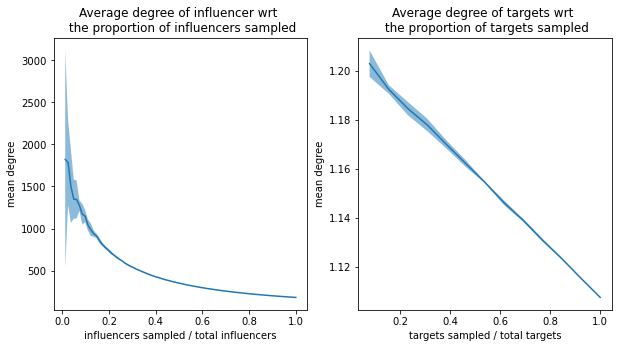

In [15]:
averages = []

for k in range(0, len(influencers), 10) :
    values = []
    for _ in range(10):
        Iprob = np.random.choice(influencers, k, p = p_influencers, replace=False) 
        values.append( gbu.loc[Iprob].mean() )
    m = sum(values) / len(values)
    s = np.std(values)
    averages.append([m - 2*s, m, m + 2*s])

df = pd.DataFrame(averages)
del(averages)

df.index = df.index / df.index.max()

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(df[1])
ax[0].fill_between(df.index, df[0],df[2], alpha = 0.5)
del(df)

ax[0].set_title("Average degree of influencer wrt \n the proportion of influencers sampled")
ax[0].set_xlabel('influencers sampled / total influencers')
ax[0].set_ylabel('mean degree')

# same for targets

l = []

for k in range(0, len(targets), 10000) :
    ll = []
    for _ in range(5):
        Tprob = np.random.choice(targets, k, p = p_targets, replace=False) 
        ll.append( gbv.loc[Tprob].mean() )
    m = sum(ll) / len(ll)
    s = np.std(ll)
    l.append([m - 2*s, m, m + 2*s])

df = pd.DataFrame(l)
del(l)
df.index = df.index / df.index.max()

ax[1].plot(df[1])
ax[1].fill_between(df.index, df[0],df[2], alpha = 0.5)
del(df)

ax[1].set_title("Average degree of targets wrt \n the proportion of targets sampled")
ax[1].set_xlabel('targets sampled / total targets')
ax[1].set_ylabel('mean degree')
plt.show()

In [16]:
nI, nT = 100, 1000
n_iter = 5

l1, l2 = [], []
for _ in range(n_iter) : 
    Irand = np.random.choice(influencers, nI, replace=False)
    Trand = np.random.choice(targets, nT, replace=False)
    XYrand = create_XY(Irand, Trand)
    l1.append((XYrand[:,:,10] > 0).sum())

    Iprob = np.random.choice(influencers, nI, p = p_influencers, replace=False)
    Tprob = np.random.choice(targets, nT, p = p_targets, replace=False)
    XYprob = create_XY(Iprob, Tprob)
    l2.append((XYprob[:,:,10] > 0).sum())

print(f"Number of positive labels with uniform distribution : {sum(l1)/n_iter}")
print(f"Number of positive labels with this distribution : {sum(l2)/n_iter}")

Number of positive labels with uniform distribution : 168.4
Number of positive labels with this distribution : 820.4


Third approach : We fix a proportion of positive labels to fill XY matrix

In [16]:

def fill_with_positive(XY, p) :
    """
    input : XY -> output of createXY, p -> proportion of positive examples needed in XY
    output : XY with the positive examples added
    """
    nI, nT, _ = XY.shape
    n_pos = int(p * nI * nT)

    labels_to_add = labels.sample(n = n_pos)
    for l in range(n_pos) :
    
        i = np.random.randint(0,nI)
        t = np.random.randint(0, nT)
    
        label = labels_to_add.iloc[l]
        fu = df_user.loc[label.u]
        fv = df_user.loc[label.v]
    
        XY[i, t, :] = np.concatenate([fu, fv, label[PROB_TYPE]], axis=None)
    
    return XY


In [17]:
XY_filled = fill_with_positive(create_XY(sampled_influencers, sampled_targets), 0.2)
print(f"p = {0.2} : Ratio of positive examples = {(XY_filled[:,:,10] > 0).sum() / (XY_filled.shape[0] * XY_filled.shape[1]) * 100}%")

p = 0.2 : Ratio of positive examples = 18.185000000000002%


### Export of resampled data

In [18]:
gbu = labels.groupby('u').count().v
influencers = list(gbu.index)
p_influencers = list(gbu.values / sum(gbu)) 
del(gbu)

gbv = labels.groupby('v').count().u
targets = list(gbv.index)
p_targets = list(gbv.values / sum(gbv))
del(gbv)

In [19]:
path = '../decision_focused_learning_gpu/instances_weibo/oversampled_FE_LP/'
PROP_POS = 0.1

for instance in range(N_INSTANCES) : 

    if instance % (N_INSTANCES // 10) == 0 : print(f"Saving instance {instance}/{N_INSTANCES}...")

    if os.path.exists(path + f'{instance}.npz') :
        print("Instance already created")
    else :
        sampled_influencers = np.random.choice(influencers, N_INFLUENCERS, p = p_influencers, replace=False)
        sampled_targets = np.random.choice(targets, N_TARGETS, p = p_targets, replace=False)

        XY = create_XY(sampled_influencers, sampled_targets)
        XY = fill_with_positive(XY, PROP_POS)

        np.savez(path + f'{instance}.npz', XY)    
        del(XY)
    
print("End")

Saving instance 0/10...
Instance already created
Saving instance 1/10...
Instance already created
Saving instance 2/10...
Instance already created
Saving instance 3/10...
Instance already created
Saving instance 4/10...
Instance already created
Saving instance 5/10...
Instance already created
Saving instance 6/10...
Instance already created
Saving instance 7/10...
Instance already created
Saving instance 8/10...
Instance already created
Saving instance 9/10...
Instance already created
End


### Adding the topology edges info to instances

In [35]:
 
edges = pd.read_pickle(file_edges)

def f(): return 0
d_edges = defaultdict(f)
for (u,v) in zip(edges.u, edges.v) :
    d_edges[(u,v)] = 1
del(edges)

def feature_vector(u,v) : 
    """
    Creates vector with
    - Influencers features
    - Target features
    - Topology link
    """
    fu = df_user.loc[u]
    fv = df_user.loc[v]
    
    return np.concatenate([fu, fv, d_edges[(u,v)]], axis = None)

d_labels = defaultdict(lambda : False)
for (u,v) in zip(labels.u, labels.v) :
    d_labels[(u,v)] = True

def fill_y_2(u,v) : 
    if d_labels[(u,v)] : 
        return labels.loc[(u,v)][PROB_TYPE]
    else : 
        return 0
@jit
def create_XY_2(sampled_influencers, sampled_targets) :
    """
    from 2 sets of influencers and targets, creates features and labels according to the paper format
    """
    nI = len(sampled_influencers)
    nT = len(sampled_targets)
    X = np.zeros((nI, nT, N_FEATURES + 1)) #adds the topology link

    Y = np.zeros((nI, nT))

    for i in range(nI):
        for j in range(nT):
            X[i,j, :] = feature_vector(sampled_influencers[i], sampled_targets[j])
            Y[i,j] = fill_y_2(sampled_influencers[i], sampled_targets[j])

    Y = np.reshape(Y, (nI, nT,1))

    return np.concatenate((X,Y), axis = 2)

def fill_with_positive_2(XY, p) :
    """
    input : XY -> output of createXY, p -> proportion of positive examples needed in XY
    output : XY with the positive examples added
    """
    nI, nT, _ = XY.shape
    n_pos = int(p * nI * nT)

    labels_to_add = labels.sample(n = n_pos)
    for l in range(n_pos) :
    
        i = np.random.randint(0,nI)
        t = np.random.randint(0, nT)
    
        label = labels_to_add.iloc[l]
        f = feature_vector(label.u, label.v)

        XY[i, t, :] = np.concatenate([f, label[PROB_TYPE]], axis=None)
    
    return XY

In [37]:
path = '../decision_focused_learning_gpu/instances_weibo/oversampled_FE_LP_2/'
PROP_POS = 0.1

for instance in range(N_INSTANCES) : 

    if instance % (N_INSTANCES // 10) == 0 : print(f"Saving instance {instance}/{N_INSTANCES}...")

    if os.path.exists(path + f'{instance}.npz') :
        print("Instance already created")
    else :
        sampled_influencers = np.random.choice(influencers, N_INFLUENCERS, p = p_influencers, replace=False)
        sampled_targets = np.random.choice(targets, N_TARGETS, p = p_targets, replace=False)

        XY = create_XY_2(sampled_influencers, sampled_targets)
        XY = fill_with_positive_2(XY, PROP_POS)

        np.savez(path + f'{instance}.npz', XY)    
        del(XY)
    
print("End")

Saving instance 0/10...
Saving instance 1/10...
Saving instance 2/10...
Saving instance 3/10...
Saving instance 4/10...
Saving instance 5/10...
Saving instance 6/10...
Saving instance 7/10...
Saving instance 8/10...
Saving instance 9/10...
End


Plots